In [1]:
#!apt-get update ; apt-get install -y graphviz libgraphviz-dev
#%pip install pydot
# %pip install tqdm
# %pip install pandas
# %pip install sklearn
# %pip install pillow
# %pip install seaborn
from tensorflow import keras
import tensorflow
import pandas as pd
import numpy as np
import functools
from time import time
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing import image as imgproc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, Flatten, AveragePooling2D, LSTM, ConvLSTM2D
from tensorflow.keras.layers import TimeDistributed, Bidirectional, GRU, Dense, Dropout, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tempfile
from sklearn.preprocessing import MinMaxScaler
import os
import random
from datetime import datetime
%load_ext tensorboard
%matplotlib inline
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tensorflow.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# Attempt to make runs more reproducible
seed_value=20212042
print("Using seed value: %d" % seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value) # tensorflow 2.x

Num GPUs Available: 1
Tensorflow version: 2.4.0
Using seed value: 20212042


## Set Parameters

In [2]:
# set up paths
base_dir = "/workspace/C684_Assignment/"
processing_dir = os.path.join(base_dir, "processing")
frames_dir = os.path.join(processing_dir, "att_maps")
train_dir = os.path.join(base_dir, "training")
train_frame_dir = os.path.join(train_dir, "train_frames")
chkp_dir = os.path.join(train_dir, "chkp")
if not os.path.exists(chkp_dir):
    os.makedirs(chkp_dir)
logs_dir = os.path.join(train_dir, "logs")
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    
# some global params
SHORT_TERM_MODEL = False
SIZE = (70, 70)
USE_ATT_MAPS = True
USE_AMNET_PRED = True
ATT_MAPS = [ 0, 1, 2 ] # full list - [ 0, 1, 2 ]
RGB = True
FRAME_INDEXES = [0, 48, 96, 144] # full list - [0, 24, 48, 72, 96, 120, 144]
BATCH_SIZE=32
TRAINING_ITERATIONS=4
EPOCHS=20
MULTIPROCESSING=True
WORKERS=8
SPEARMAN_THRESHOLD = 0.43 if SHORT_TERM_MODEL else 0.2
CHANNELS = len(ATT_MAPS) * (3 if RGB else 1)
NBFRAME = len(FRAME_INDEXES)

## Load Train and Test Data

In [3]:
# load data
amnet_preds = pd.read_csv(os.path.join(processing_dir, "all_amnet_pred.csv")).set_index("video")
amnet_preds["Y_pred"] = MinMaxScaler().fit_transform(amnet_preds["Y_pred"].values.reshape(-1, 1))
display(amnet_preds["Y_pred"].describe())
dev_videos = pd.read_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))
dev_videos_train = dev_videos[dev_videos["test"]==False]
dev_videos_test = dev_videos[dev_videos["test"]==True]

count    224000.000000
mean          0.600106
std           0.160918
min           0.000000
25%           0.487308
50%           0.628983
75%           0.726435
max           1.000000
Name: Y_pred, dtype: float64

## Plot Ground Truth Memorability Histograms

Train size: 5100. Test size: 900


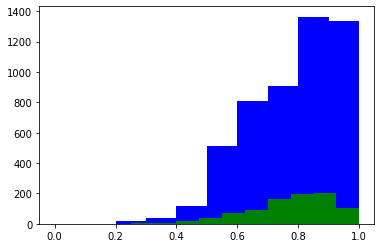

In [4]:
# train/test y_true histogram
X_train = dev_videos_train["video"]
y_train = dev_videos_train["short-term_memorability"] if SHORT_TERM_MODEL else dev_videos_train["long-term_memorability"]
X_test = dev_videos_test["video"]
y_test = dev_videos_test["short-term_memorability"] if SHORT_TERM_MODEL else dev_videos_test["long-term_memorability"]
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print("Train size: %d. Test size: %d" % (train_size, test_size))
plt.hist(y_train, color='blue')
plt.hist(y_test, color='green')
plt.show()

## Calculate Baseline Performance

In [5]:
# calculate AMNet scores
def calc_spearman(a1, a2):
    Res = pd.DataFrame()
    Res["Y_true"] = a1
    Res["Y_pred"] = a2
    return Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]

amnet_short_score = calc_spearman(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_long_score = calc_spearman(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
print("AMNet Overall: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
print("AMNet Train: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
print("AMNet Test: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))

AMNet Overall: short-term score=0.4183|mse=0.0194, long-term score=0.2143|mse=0.0232
AMNet Train: short-term score=0.4175|mse=0.0194, long-term score=0.2196|mse=0.0231
AMNet Test: short-term score=0.4214|mse=0.0195, long-term score=0.1867|mse=0.0235


## Define Generator and Callback Classes

In [6]:
class TrainTestSequence(Sequence):
    def __init__(self, X_set, y_set, do_shuffle):
        self.x, self.y = X_set, y_set
        self.do_shuffle = do_shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.x) // BATCH_SIZE
    
    def _load_images(self, batch):
        images = np.zeros((len(batch), NBFRAME, SIZE[0], SIZE[1], CHANNELS))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                filename = "%s_%d_att.jpg" % (video, frame_index)
                pilimg = []
                for img_index in ATT_MAPS:
                    dirname = "%s-%d" % (train_frame_dir, img_index)
                    img = imgproc.load_img(os.path.join(dirname, filename))
                    if not RGB:
                        img = img.convert('L')
                    img = img.resize(SIZE)
                    img = imgproc.img_to_array(img)
                    pilimg.append(img)
                images[video_index][sequence_index] = np.concatenate(pilimg, axis=2) / 255.
        return images
    
    def _load_amnet_preds(self, batch):
        batch_amnet_preds = np.zeros((len(batch), NBFRAME))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                frame_id = "%s_%d" % (video, frame_index)
                batch_amnet_preds[video_index][sequence_index] = amnet_preds.loc[frame_id, "Y_pred"]
        return batch_amnet_preds
    
    def on_epoch_end(self):
        if self.do_shuffle:
            self.x, self.y = shuffle(self.x, self.y)
            
    def __getitem__(self, idx):
        batch_x = self.x[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_y = self.y[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_x_features = []
        if USE_ATT_MAPS:
            batch_x_features.append(self._load_images(batch_x))
        if USE_AMNET_PRED:
            batch_x_features.append(self._load_amnet_preds(batch_x))
        return batch_x_features, np.array(batch_y)

def make_generator(X_set, y_set, shuffle, worker_count):
    seq = TrainTestSequence(X_set, y_set, shuffle)
    enq = OrderedEnqueuer(seq, use_multiprocessing=MULTIPROCESSING, shuffle=shuffle)
    enq.start(workers=worker_count, max_queue_size=worker_count*20)
    return enq

class SpearmanCalcCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, batch_size, worker_count):
        batch_remainder = y_test.shape[0] % batch_size
        self.steps = y_test.shape[0] // batch_size
        self.y_test = y_test[:-batch_remainder]
        self.X_test = X_test[:-batch_remainder]
        self.worker_count = worker_count
        self.generator = make_generator(self.X_test, self.y_test, False, self.worker_count)
        
    def on_epoch_end(self, zero_based_epoch, logs=None):
        epoch = zero_based_epoch + 1
        y_pred = self.model.predict(self.generator.get(), steps=self.steps)
        
        # reset generator before next epoch
        self.generator.stop()
        self.generator.start(workers=self.worker_count)
        
        Res = pd.DataFrame()
        Res["Y_true"] = self.y_test
        Res["Y_pred"] = y_pred
        score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]
        print()
        print("*** Epoch %d: Spearman's correlation = %.4f" % (epoch, score_mat))
        mse = mean_squared_error(Res["Y_true"], Res["Y_pred"])
        print("*** Epoch %d: MSE = %.4f" % (epoch, mse))
        plt.hist(y_pred)
        plt.show()
            
        if score_mat > SPEARMAN_THRESHOLD:
            model_file = os.path.join(chkp_dir, "weights-%.04f-%s-%d.hdf5" % (score_mat, self.run_id, epoch))
            print("*** Saving model to file %s" % model_file)
            model.save(model_file)
        print()

    def set_run(self, run_id, model):
        timestamp = datetime.now().strftime("%d_%m_%Y_%H_%M")
        self.run_id = "%s-%d" % (timestamp, run_id)
        self.model = model
        return self
    
    def evaluate_model(self, model):
        self.set_run(0, model)
        self.on_epoch_end(-1)

## Define Model

In [7]:
# define model
def functional_model(shape=(NBFRAME,) + SIZE + (CHANNELS,)):
    frame_inputs = keras.Input(shape=shape)
    f = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(frame_inputs)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 3, 3), padding='same')(f)
    f = ConvLSTM2D(filters=5, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = TimeDistributed(Flatten())(f)
    f = TimeDistributed(Dense(512))(f)
    f = TimeDistributed(Dropout(0.5))(f)
    f = TimeDistributed(Dense(64))(f)
    f = Flatten()(f)
    f = Dense(128)(f)
    pred_inputs = keras.Input(shape=(NBFRAME,1,))
    p = keras.layers.LSTM(32, return_sequences=True)(pred_inputs)
    p = keras.layers.LSTM(32, return_sequences=True)(p)
    p = Flatten()(p)
    p = Dense(128)(p)
    
    inputs = None
    if USE_ATT_MAPS and USE_AMNET_PRED:
        f = keras.layers.Average()([f, p])
        inputs = [frame_inputs, pred_inputs]
    elif USE_ATT_MAPS:
        inputs = [frame_inputs]
    elif USE_AMNET_PRED:
        f = p
        inputs = [pred_inputs]
    else:
        raise Exception("USE_ATT_MAPS and/or USE_AMNET_PRED needs to be True")

    f = keras.layers.BatchNormalization()(f)
    f = Dense(64)(f)
    f = Dense(1, activation='sigmoid')(f)
    model = keras.Model(inputs=inputs, outputs=f)
    
    # display layer information
    print(model.summary())
    keras.utils.plot_model(model)
    
    return model

## Train Model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 70, 70, 9 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 4, 70, 70, 20 20960       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 4, 35, 35, 20 0           conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 4, 35, 35, 10 10840       max_pooling3d[0][0]              
______________________________________________________________________________________________

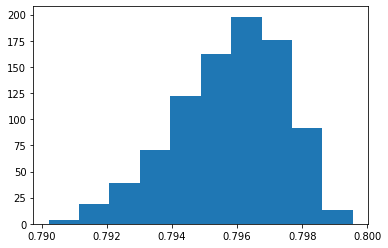


Epoch 2/20
159/159 [==============================] - 100s 626ms/step - loss: 0.0215

*** Epoch 1: Spearman's correlation = 0.1831

*** Epoch 2: Spearman's correlation = 0.1915
*** Epoch 2: MSE = 0.0205


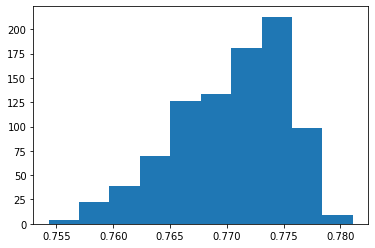


Epoch 3/20
159/159 [==============================] - 93s 583ms/step - loss: 0.0207

*** Epoch 2: Spearman's correlation = 0.1915

*** Epoch 3: Spearman's correlation = 0.1896
*** Epoch 3: MSE = 0.0203


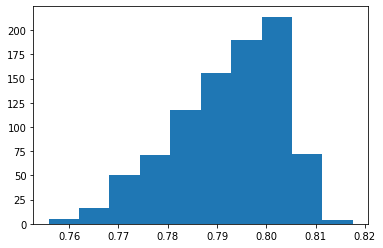


Epoch 4/20
159/159 [==============================] - 88s 551ms/step - loss: 0.0213


*** Epoch 4: Spearman's correlation = 0.1874
*** Epoch 4: MSE = 0.0203


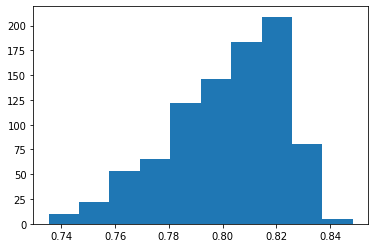


Epoch 5/20
159/159 [==============================] - 82s 517ms/step - loss: 0.0207

*** Epoch 4: Spearman's correlation = 0.1874

*** Epoch 5: Spearman's correlation = 0.2086
*** Epoch 5: MSE = 0.0197


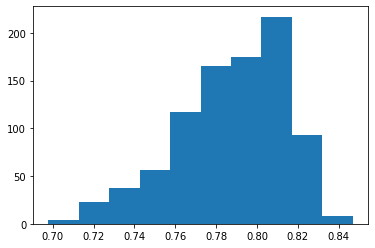

*** Saving model to file /workspace/C684_Assignment/training/chkp/weights-0.2086-27_04_2021_20_07-0-5.hdf5

Epoch 6/20
159/159 [==============================] - 84s 526ms/step - loss: 0.0197

*** Epoch 6: Spearman's correlation = 0.2026
*** Epoch 6: MSE = 0.0225


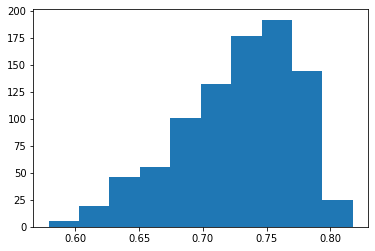

*** Saving model to file /workspace/C684_Assignment/training/chkp/weights-0.2026-27_04_2021_20_07-0-6.hdf5

Epoch 7/20
159/159 [==============================] - 85s 537ms/step - loss: 0.0204

*** Epoch 7: Spearman's correlation = 0.2038
*** Epoch 7: MSE = 0.0209


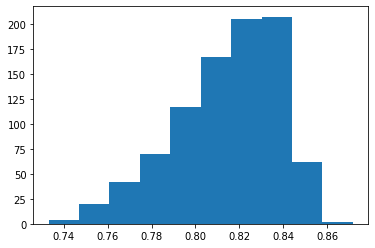

*** Saving model to file /workspace/C684_Assignment/training/chkp/weights-0.2038-27_04_2021_20_07-0-7.hdf5

Epoch 8/20
159/159 [==============================] - 85s 533ms/step - loss: 0.0202
*** Epoch 7: MSE = 0.0209

*** Epoch 8: Spearman's correlation = 0.1816
*** Epoch 8: MSE = 0.0198


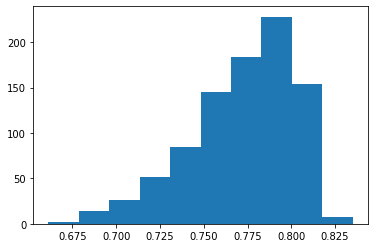


Epoch 9/20
159/159 [==============================] - 85s 537ms/step - loss: 0.0203
*** Epoch 8: MSE = 0.0198

*** Epoch 9: Spearman's correlation = 0.1843
*** Epoch 9: MSE = 0.0248


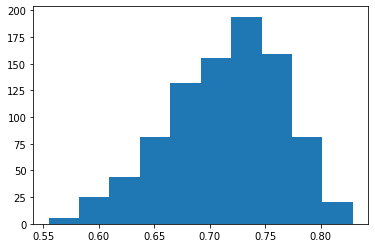


Epoch 10/20
159/159 [==============================] - 91s 571ms/step - loss: 0.0198

*** Epoch 10: Spearman's correlation = 0.1953
*** Epoch 10: MSE = 0.0201


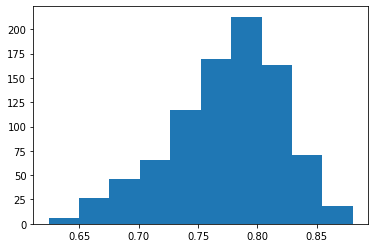


Epoch 11/20
159/159 [==============================] - 86s 539ms/step - loss: 0.0204

*** Epoch 11: Spearman's correlation = 0.2005
*** Epoch 11: MSE = 0.0198


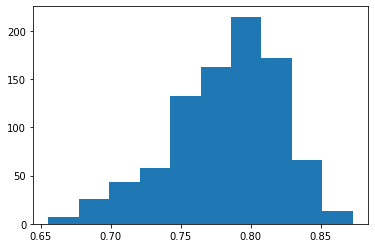

*** Saving model to file /workspace/C684_Assignment/training/chkp/weights-0.2005-27_04_2021_20_07-0-11.hdf5

Epoch 12/20
159/159 [==============================] - 87s 549ms/step - loss: 0.0188

*** Epoch 12: Spearman's correlation = 0.1958
*** Epoch 12: MSE = 0.0202


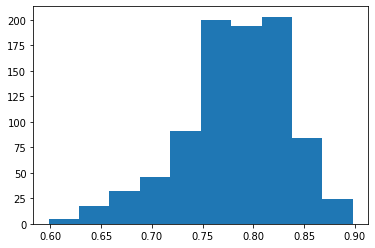


Epoch 13/20
159/159 [==============================] - 83s 523ms/step - loss: 0.0197

*** Epoch 13: Spearman's correlation = 0.1910
*** Epoch 13: MSE = 0.0199


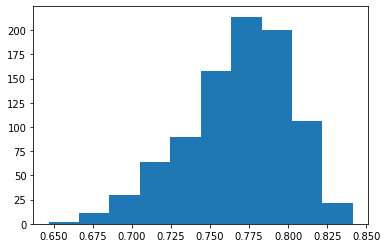


Epoch 14/20
159/159 [==============================] - 92s 580ms/step - loss: 0.0201
*** Epoch 13: MSE = 0.0199

*** Epoch 14: Spearman's correlation = 0.1744
*** Epoch 14: MSE = 0.0203


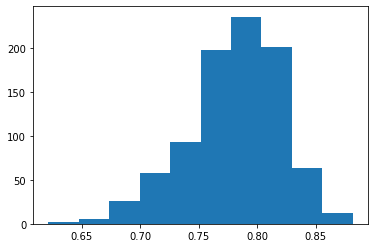


Epoch 15/20
159/159 [==============================] - 87s 549ms/step - loss: 0.0191

*** Epoch 15: Spearman's correlation = 0.1403
*** Epoch 15: MSE = 0.0210


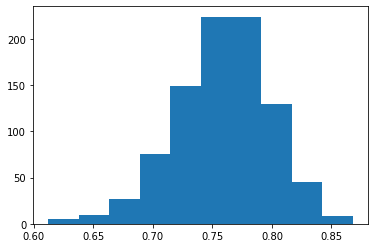


Epoch 16/20
159/159 [==============================] - 85s 534ms/step - loss: 0.0190

*** Epoch 16: Spearman's correlation = 0.1542
*** Epoch 16: MSE = 0.0211


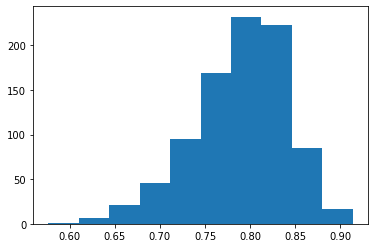


Epoch 17/20
159/159 [==============================] - 88s 551ms/step - loss: 0.0193

*** Epoch 16: Spearman's correlation = 0.1542WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

*** Epoch 17: Spearman's correlation = 0.1233
*** Epoch 17: MSE = 0.0221


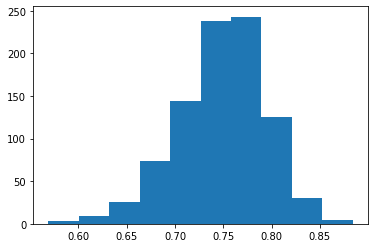


Epoch 18/20
159/159 [==============================] - 84s 525ms/step - loss: 0.0183

*** Epoch 18: Spearman's correlation = 0.1236
*** Epoch 18: MSE = 0.0205


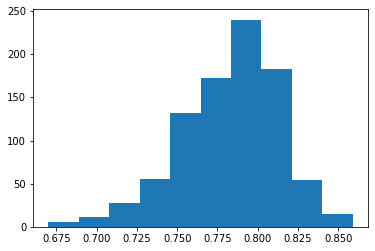


Epoch 19/20
159/159 [==============================] - 82s 518ms/step - loss: 0.0172

*** Epoch 18: Spearman's correlation = 0.1236
*** Epoch 18: MSE = 0.0205

*** Epoch 19: Spearman's correlation = 0.0967
*** Epoch 19: MSE = 0.0218


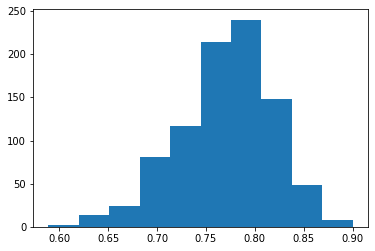


Epoch 20/20
159/159 [==============================] - 84s 528ms/step - loss: 0.0177

*** Epoch 20: Spearman's correlation = 0.0808
*** Epoch 20: MSE = 0.0220


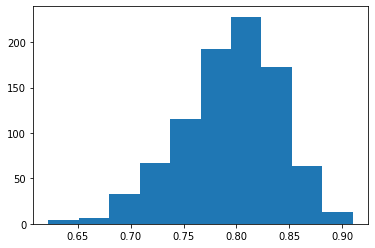


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 70, 70, 9 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)     (None, 4, 70, 70, 20 20960       input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_3 (MaxPooling3D)  (None, 4, 35, 35, 20 0           conv_lst_m2d_3[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)     (None, 4, 35, 35, 10 10840       max_pooling3d_3[0][0]            
___________________________________________________________________________________________

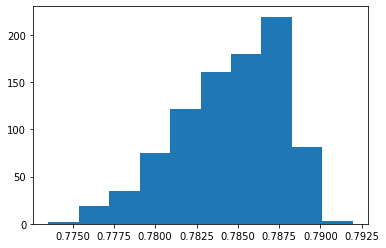


Epoch 2/20
159/159 [==============================] - 85s 532ms/step - loss: 0.0206

*** Epoch 2: Spearman's correlation = 0.1702
*** Epoch 2: MSE = 0.0205


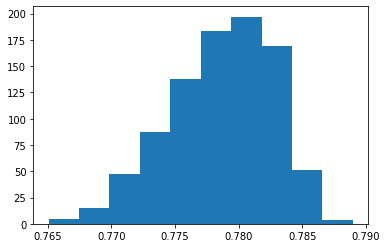


Epoch 3/20
159/159 [==============================] - 89s 558ms/step - loss: 0.0203

*** Epoch 2: MSE = 0.0205

*** Epoch 3: Spearman's correlation = 0.1693
*** Epoch 3: MSE = 0.0203


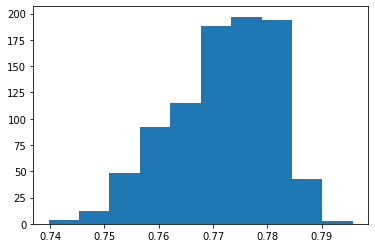


Epoch 4/20
159/159 [==============================] - 89s 563ms/step - loss: 0.0215

*** Epoch 3: Spearman's correlation = 0.1693
*** Epoch 3: MSE = 0.0203WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

*** Epoch 4: Spearman's correlation = 0.1811
*** Epoch 4: MSE = 0.0202


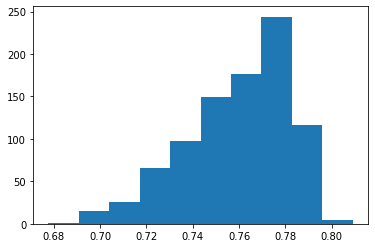


Epoch 5/20
159/159 [==============================] - 87s 548ms/step - loss: 0.0208

*** Epoch 5: Spearman's correlation = 0.1748
*** Epoch 5: MSE = 0.0266


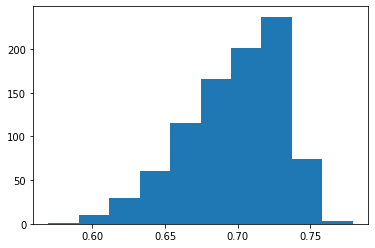


Epoch 6/20
159/159 [==============================] - 83s 520ms/step - loss: 0.0209

*** Epoch 6: Spearman's correlation = 0.1851
*** Epoch 6: MSE = 0.0212


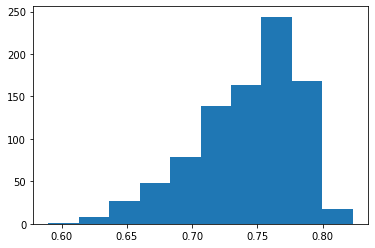


Epoch 7/20
159/159 [==============================] - 86s 540ms/step - loss: 0.0205

*** Epoch 6: Spearman's correlation = 0.1851
*** Epoch 6: MSE = 0.0212

*** Epoch 7: Spearman's correlation = 0.1927
*** Epoch 7: MSE = 0.0198


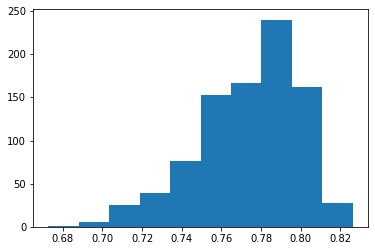


Epoch 8/20
159/159 [==============================] - 88s 550ms/step - loss: 0.0198

*** Epoch 8: Spearman's correlation = 0.1883
*** Epoch 8: MSE = 0.0198


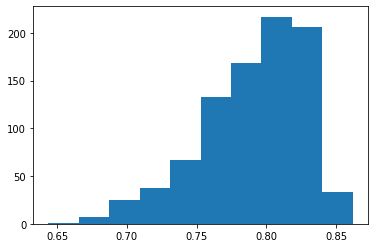


Epoch 9/20
159/159 [==============================] - 87s 547ms/step - loss: 0.0200
*** Epoch 8: Spearman's correlation = 0.1883
*** Epoch 8: MSE = 0.0198

*** Epoch 9: Spearman's correlation = 0.1883
*** Epoch 9: MSE = 0.0198


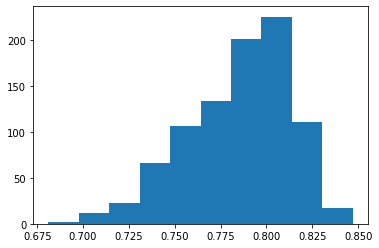


Epoch 10/20
159/159 [==============================] - 83s 520ms/step - loss: 0.0198
*** Epoch 9: MSE = 0.0198

*** Epoch 10: Spearman's correlation = 0.1711
*** Epoch 10: MSE = 0.0201


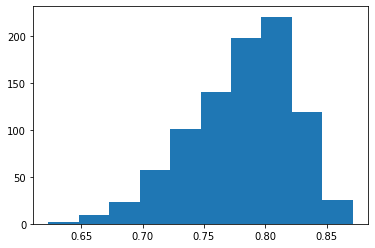


Epoch 11/20
159/159 [==============================] - 119s 752ms/step - loss: 0.0198

*** Epoch 10: Spearman's correlation = 0.1711

*** Epoch 11: Spearman's correlation = 0.1715
*** Epoch 11: MSE = 0.0218


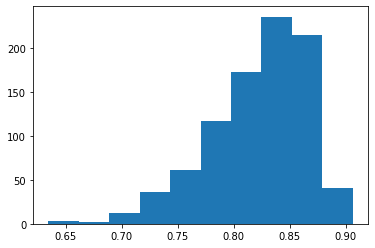


Epoch 12/20
159/159 [==============================] - 111s 701ms/step - loss: 0.0192

*** Epoch 11: Spearman's correlation = 0.1715

*** Epoch 12: Spearman's correlation = 0.1651
*** Epoch 12: MSE = 0.0208


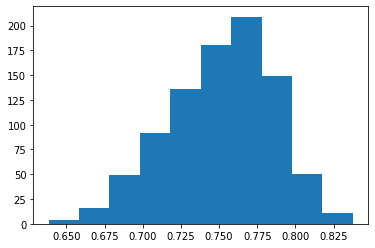


Epoch 13/20
159/159 [==============================] - 104s 658ms/step - loss: 0.0200

*** Epoch 12: MSE = 0.0208

*** Epoch 13: Spearman's correlation = 0.1838
*** Epoch 13: MSE = 0.0212


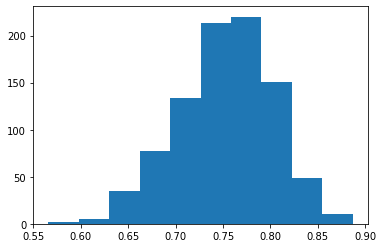


Epoch 14/20
159/159 [==============================] - 90s 566ms/step - loss: 0.0192


*** Epoch 14: Spearman's correlation = 0.1008
*** Epoch 14: MSE = 0.0244


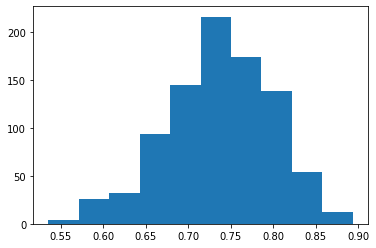


Epoch 15/20
159/159 [==============================] - 98s 620ms/step - loss: 0.0177

*** Epoch 14: Spearman's correlation = 0.1008
*** Epoch 14: MSE = 0.0244

*** Epoch 15: Spearman's correlation = 0.1743
*** Epoch 15: MSE = 0.0208


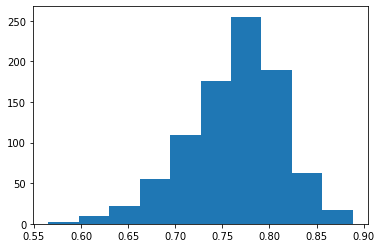


Epoch 16/20
159/159 [==============================] - 116s 729ms/step - loss: 0.0191

*** Epoch 16: Spearman's correlation = 0.1374
*** Epoch 16: MSE = 0.0224


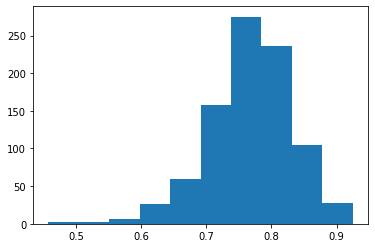


Epoch 17/20
159/159 [==============================] - 119s 749ms/step - loss: 0.0183

*** Epoch 16: Spearman's correlation = 0.1374

*** Epoch 17: Spearman's correlation = 0.1420
*** Epoch 17: MSE = 0.0258


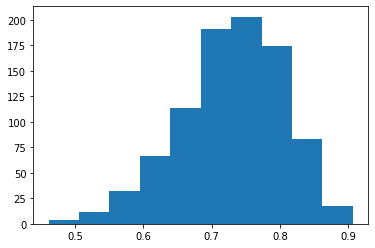


Epoch 18/20
159/159 [==============================] - 95s 596ms/step - loss: 0.0180


*** Epoch 18: Spearman's correlation = 0.1614
*** Epoch 18: MSE = 0.0219


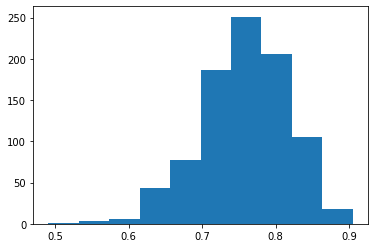


Epoch 19/20
159/159 [==============================] - 132s 833ms/step - loss: 0.0166

*** Epoch 19: Spearman's correlation = 0.1680
*** Epoch 19: MSE = 0.0214


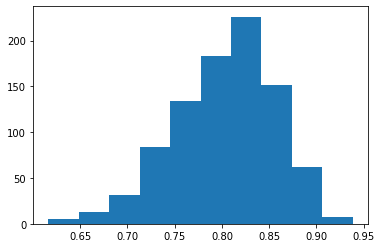


Epoch 20/20
159/159 [==============================] - 112s 704ms/step - loss: 0.0159

*** Epoch 20: Spearman's correlation = 0.1995
*** Epoch 20: MSE = 0.0207


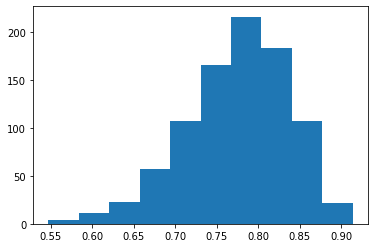


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4, 70, 70, 9 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)     (None, 4, 70, 70, 20 20960       input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_6 (MaxPooling3D)  (None, 4, 35, 35, 20 0           conv_lst_m2d_6[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)     (None, 4, 35, 35, 10 10840       max_pooling3d_6[0][0]            
___________________________________________________________________________________________

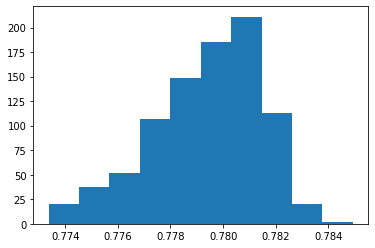


Epoch 2/20
159/159 [==============================] - 87s 545ms/step - loss: 0.0213


*** Epoch 2: Spearman's correlation = 0.1835
*** Epoch 2: MSE = 0.0205


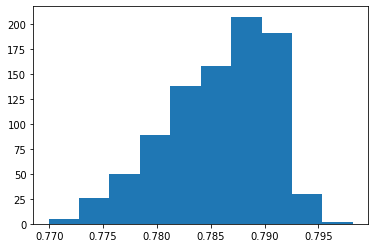


Epoch 3/20
159/159 [==============================] - 86s 541ms/step - loss: 0.0205

*** Epoch 3: Spearman's correlation = 0.1905
*** Epoch 3: MSE = 0.0212


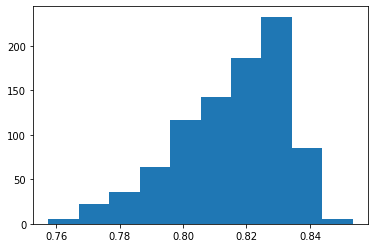


Epoch 4/20
159/159 [==============================] - 88s 553ms/step - loss: 0.0210

*** Epoch 4: Spearman's correlation = 0.1854
*** Epoch 4: MSE = 0.0199


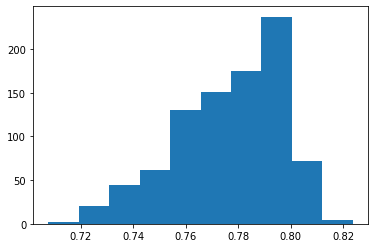


Epoch 5/20
159/159 [==============================] - 86s 541ms/step - loss: 0.0205

*** Epoch 5: Spearman's correlation = 0.1879
*** Epoch 5: MSE = 0.0199


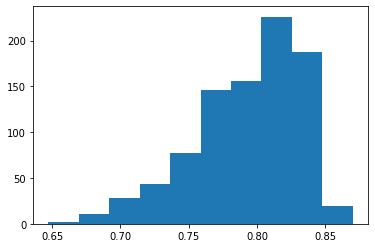


Epoch 6/20
159/159 [==============================] - 88s 556ms/step - loss: 0.0202

*** Epoch 5: Spearman's correlation = 0.1879
*** Epoch 5: MSE = 0.0199

*** Epoch 6: Spearman's correlation = 0.1850
*** Epoch 6: MSE = 0.0199


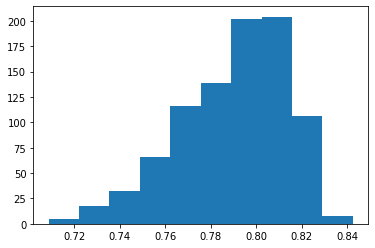


Epoch 7/20
159/159 [==============================] - 86s 540ms/step - loss: 0.0204
*** Epoch 6: Spearman's correlation = 0.1850
*** Epoch 6: MSE = 0.0199

*** Epoch 7: Spearman's correlation = 0.1865
*** Epoch 7: MSE = 0.0212


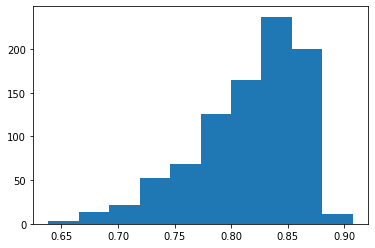


Epoch 8/20
159/159 [==============================] - 92s 580ms/step - loss: 0.0203
*** Epoch 7: MSE = 0.0212

*** Epoch 8: Spearman's correlation = 0.1745
*** Epoch 8: MSE = 0.0219


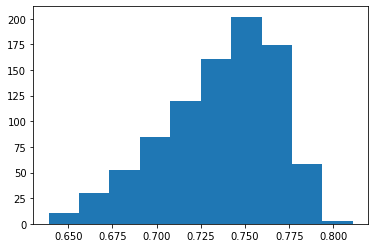


Epoch 9/20
159/159 [==============================] - 88s 552ms/step - loss: 0.0207

*** Epoch 8: Spearman's correlation = 0.1745WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

*** Epoch 9: Spearman's correlation = 0.1781
*** Epoch 9: MSE = 0.0222


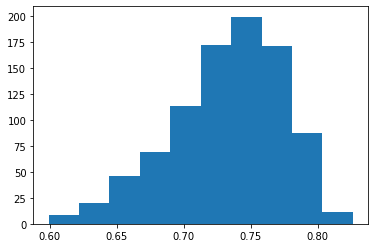


Epoch 10/20
159/159 [==============================] - 87s 549ms/step - loss: 0.0195


*** Epoch 10: Spearman's correlation = 0.1810
*** Epoch 10: MSE = 0.0203


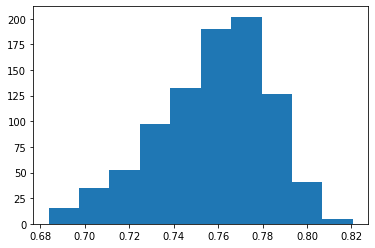


Epoch 11/20
159/159 [==============================] - 93s 587ms/step - loss: 0.0202

*** Epoch 10: Spearman's correlation = 0.1810

*** Epoch 11: Spearman's correlation = 0.1802
*** Epoch 11: MSE = 0.0204


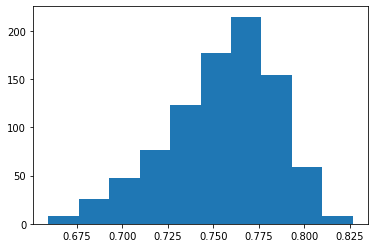


Epoch 12/20
159/159 [==============================] - 87s 545ms/step - loss: 0.0197

*** Epoch 12: Spearman's correlation = 0.1873
*** Epoch 12: MSE = 0.0212


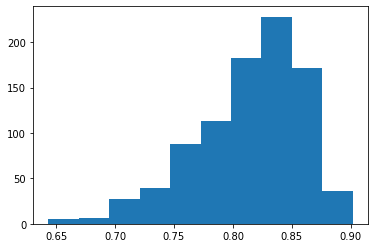


Epoch 13/20
159/159 [==============================] - 86s 541ms/step - loss: 0.0200
*** Epoch 12: Spearman's correlation = 0.1873
*** Epoch 12: MSE = 0.0212

*** Epoch 13: Spearman's correlation = 0.0971
*** Epoch 13: MSE = 0.0216


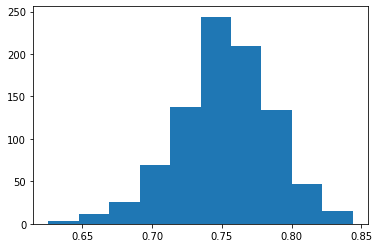


Epoch 14/20
 10/159 [>.............................] - ETA: 1:17 - loss: 0.0209

Process Keras_worker_ForkPoolWorker-1267:
Process Keras_worker_ForkPoolWorker-1282:
Process Keras_worker_ForkPoolWorker-1268:
Process Keras_worker_ForkPoolWorker-1287:
Process Keras_worker_ForkPoolWorker-1270:
Process Keras_worker_ForkPoolWorker-1272:
Process Keras_worker_ForkPoolWorker-1284:
Process Keras_worker_ForkPoolWorker-1271:
Process Keras_worker_ForkPoolWorker-1265:
Process Keras_worker_ForkPoolWorker-1285:
Process Keras_worker_ForkPoolWorker-1286:
Process Keras_worker_ForkPoolWorker-1281:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1283:
Process Keras_worker_ForkPoolWorker-1266:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1269:
Process Keras_worker_ForkPoolWorker-1288:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
   

  File "<ipython-input-6-d4a43571e59c>", line 44, in __getitem__
    batch_x_features.append(self._load_images(batch_x))
  File "<ipython-input-6-d4a43571e59c>", line 18, in _load_images
    img = imgproc.load_img(os.path.join(dirname, filename))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-6-d4a43571e59c>", line 24, in _load_images
    images[video_index][sequence_index] = np.concatenate(pilimg, axis=2) / 255.
KeyboardInterrupt
  File "<ipython-input-6-d4a43571e59c>", line 44, in __getitem__
    batch_x_features.append(self._load_images(batch_x))
  File "<ipython-input-6-d4a43571e59c>", line 18, in _load_images
    img = imgproc.load_img(os.path.join(dirname, filename))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwa


*** Epoch 13: Spearman's correlation = 0.0971


  File "<ipython-input-6-d4a43571e59c>", line 44, in __getitem__
    batch_x_features.append(self._load_images(batch_x))
KeyboardInterrupt
  File "/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
KeyboardInterrupt
KeyboardInterrupt
  File "<ipython-input-6-d4a43571e59c>", line 18, in _load_images
    img = imgproc.load_img(os.path.join(dirname, filename))
KeyboardInterrupt
  File "/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 2953, in open
    im = _open_core(fp, filename, prefix, formats)
KeyboardInterrupt
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/preprocessing/image.py", line 299, in load_img
    return image.load_img(path, grayscale=grayscale, color_mode=color_mode,
  File "/usr/local/lib/python3.

KeyboardInterrupt: 

In [8]:
# train model
train_generator = make_generator(X_train, y_train, True, WORKERS).get()
validation_callback = SpearmanCalcCallback(X_test, y_test, BATCH_SIZE, WORKERS)
for attempt in range(TRAINING_ITERATIONS):
    model = functional_model()
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    callbacks = [
        keras.callbacks.TensorBoard(log_dir=os.path.join(logs_dir, "{}".format(time()))),
        validation_callback.set_run(attempt, model)
    ]
    model.fit(train_generator,
              epochs=EPOCHS,
              steps_per_epoch=train_size//BATCH_SIZE,
              callbacks=callbacks)